# Clusterizador com UNet

## Imports

In [ ]:
import torch
import torch.nn as nn

import torchvision.transforms.functional as TF

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import random

import torch.optim as optim

'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
from torch import sigmoid
from torch.nn.modules.upsampling import Upsample
from torch.nn.functional import interpolate
from torch.autograd import Variable
from torch.nn import MaxPool2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import Sigmoid, ReLU

from torchsummary import summary

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
'''

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

from os import listdir
from os.path import isfile, join

from tqdm import tqdm

import random

import torch
from torch import nn, sigmoid
from torch.nn.modules.upsampling import Upsample
from torch.nn.functional import interpolate
from torch.autograd import Variable
from torch.nn import MaxPool2d
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.activation import Sigmoid, ReLU
# from Encoders import global_attention 

from torchsummary import summary

from google.colab import drive

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance

from torchsummary import summary

import torchvision.transforms as transforms

## Utils

In [ ]:
class CustomDataset():
    
    def __init__(self, dataset, transform=None):
        
        self.images    = []
        self.targets   = []
        self.transform = transform

        for i in range(len(dataset)):

            self.images.append(dataset[i][0])
            self.targets.append(dataset[i][1])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
        image  = self.images[index] 
        target = self.targets[index] 
        
        if self.transform:
            image = self.transform(image)
            
        return (image, index, target)

In [ ]:
def cluster_test(dataset, model):

    valid_loader = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=0, shuffle=False)
    o, l = [], []
    lab, out = [], []

    model.eval()

    for inputs in valid_loader:        

        images, labels = inputs
        images = images.to(device)

        output = model.encoder(images.float())
        output = output.to("cpu")
        output = torch.mean(output, dim = (-2, -1))

        output = output.detach().numpy()
        labels = labels.numpy()

        o.append(output)
        l.append(labels)    

    for i in range(len(l)):
        for j in range(len(o[i])):
            lab.append(l[i][j])
            out.append(o[i][j])

    kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.01, verbose=0, random_state=None, copy_x=True, algorithm='elkan')
    label = kmeans.fit_predict(out)

    i00, i01, i02 = 0, 0, 0
    i10, i11, i12 = 0, 0, 0
    i20, i21, i22 = 0, 0, 0

    for i in range(len(label)):

        if lab[i] == 0 and label[i] == 0:
            i00 += 1
        if lab[i] == 0 and label[i] == 1:
            i01 += 1
        if lab[i] == 0 and label[i] == 2:
            i02 += 1

        if lab[i] == 1 and label[i] == 0:
            i10 += 1
        if lab[i] == 1 and label[i] == 1:
            i11 += 1
        if lab[i] == 1 and label[i] == 2:
            i12 += 1

        if lab[i] == 2 and label[i] == 0:
            i20 += 1
        if lab[i] == 2 and label[i] == 1:
            i21 += 1
        if lab[i] == 2 and label[i] == 2:
            i22 += 1

    p = [[i00, i01, i02],
        [i10, i11, i12],
        [i20, i21, i22]]

    return p

In [ ]:
def mult_channels(img_one, channels=3, corrigir=False, random=False, show=False):
    
    if corrigir: img_one = np.interp(img_one, (np.min(img_one), 0.5, np.max(img_one)), (0, 0.5, 1))

    B = []
    for i in range(channels):
        B.append(img_one)    

    if show:

        plt.imshow(np.transpose(B, (1, 2, 0))) 
        plt.show()

    return B

In [ ]:
def transform_signal(img_one, inteiro=False, show=False, corrigir=False, random=False, channels=3, dobro=False):
    
    meio = np.mean(img_one, axis=0)

    add = len(img_one) % channels

    img = []

    if dobro:
        for i in img_one:
            img.append(i)
            img.append(i)

        img_dob = np.asarray(img)

        add = len(img_dob) % channels
        
        if add != 0:
            add = channels - add
            a = img_dob
            for i in range(add):
                a = np.vstack((a, meio))
        else:
            a = img_dob
    else:

        if add != 0:
            add = channels - add
            a = img_one
            for i in range(add):
                a = np.vstack((a, meio))
        else:
            a = img_one
    
    if random: np.random.shuffle(a)

    if inteiro:
        Ih = 1 - np.max(a)
        Il = np.min(a)

        if Ih < Il:
            sup = 1
            inf = 0.5 - ((0.5 * (0.5 - np.min(a)))/(np.max(a) - 0.5))
        else:
            inf = 0
            sup = 0.5 + ((0.5 * (np.max(a) - 0.5))/(0.5 - np.min(a)))

        a = np.interp(a, (np.min(a), 0.5, np.max(a)), (inf, 0.5, sup))

    B = []
    length = len(a) // channels
    for i in range(channels):

        B.append(a[length*i : length*(i+1)])    
        
    if corrigir:
        for j in range(channels):

            Ih = 1 - np.max(B[j])
            Il = np.min(B[j])

            if Ih < Il:
                sup = 1
                inf = 0.5 - ((0.5 * (0.5 - np.min(B[j])))/(np.max(B[j]) - 0.5))
            else:
                inf = 0
                sup = 0.5 + ((0.5 * (np.max(B[j]) - 0.5))/(0.5 - np.min(B[j])))

            B[j] = np.interp(B[j], (np.min(B[j]), 0.5, np.max(B[j])), (inf, 0.5, sup))

    if show:

        plt.imshow(np.transpose(B, (1, 2, 0))) 
        plt.show()

    return B

In [ ]:
def one_one(img_one):
    return [np.interp(img_one, (np.min(img_one), 0.5, np.max(img_one)), (0, 0.5, 1))]

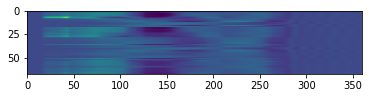

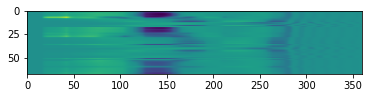

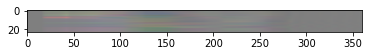

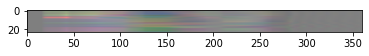

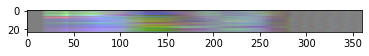

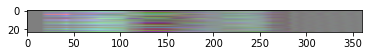

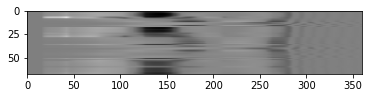

In [ ]:
t = dataset_CC

j = 100

def imshow(img):
    plt.imshow(np.transpose(img, (0, 1))) 
    plt.show()

imshow(t[j][0])
imshow(one_one(t[j][0])[0])

c = transform_signal(t[j][0], inteiro=False, show=True, corrigir=False, random=False, dobro=False) # Teste 1
c = transform_signal(t[j][0], inteiro=True,  show=True, corrigir=False, random=False, dobro=False) # Teste 2
c = transform_signal(t[j][0], inteiro=True,  show=True, corrigir=True,  random=False, dobro=False) # Teste 3
c = transform_signal(t[j][0], inteiro=True,  show=True, corrigir=True,  random=True, dobro=False)  # Teste 4
c = transform_signal(t[j][0], inteiro=True,  show=False, corrigir=True,  random=True, channels=2, dobro=True)  # Teste 5
c = transform_signal(t[j][0], inteiro=True,  show=False, corrigir=True,  random=True, channels=4, dobro=True)  # Teste 6
c = mult_channels(t[j][0], channels=3, corrigir=True, random=True, show=True)  # Teste 7

In [ ]:
t = dataset_CC

j = 100

def imshow(img):
    plt.imshow(np.transpose(img, (0, 1))) 
    plt.show()

imshow(t[j][0])
imshow(one_one(t[j][0])[0])

c = transform_signal(t[j][0], inteiro=False, show=True, corrigir=False, random=False, dobro=False) # Teste 1
c = transform_signal(t[j][0], inteiro=True,  show=True, corrigir=False, random=False, dobro=False) # Teste 2
c = transform_signal(t[j][0], inteiro=True,  show=True, corrigir=True,  random=False, dobro=False) # Teste 3
c = transform_signal(t[j][0], inteiro=True,  show=True, corrigir=True,  random=True, dobro=False)  # Teste 4
c = transform_signal(t[j][0], inteiro=True,  show=False, corrigir=True,  random=True, channels=2, dobro=True)  # Teste 5
c = transform_signal(t[j][0], inteiro=True,  show=False, corrigir=True,  random=True, channels=4, dobro=True)  # Teste 6
c = mult_channels(t[j][0], channels=3, corrigir=True, random=True, show=True)  # Teste 7

In [ ]:
def check_accuracy(loader, model):
    
    valid_loss = 0
        
    model.eval()
    
    with torch.no_grad():
        
        for data in loader:
            
            images, _, _ = data
            images       = images.to(device).float()
            
            outputs = model(images)          
            loss    = criterion(outputs.float(), images.float())

            valid_loss += loss.item()*images.size(0)
    
        valid_loss = valid_loss/len(loader)
    
    return valid_loss

In [ ]:
def precision_matrix(matrix):    
    
    np_matrix = np.array(matrix)
    soma = 0

    soma += np_matrix.max()
    row, col = int(np_matrix.argmax() / 3), int(np_matrix.argmax() % 3)
    b = np.delete(np_matrix, row, 0)
    b = np.delete(b, col, 1)

    soma += b.max()
    row, col = int(b.argmax() / 2), int(b.argmax() % 2)
    b = np.delete(b, row, 0)
    b = np.delete(b, col, 1)
    
    soma += b[0][0]
    
    return (100 * soma) / (np_matrix[0].sum()*3)

## Data and Google Drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
pathCC = "/content/drive/MyDrive/Guilherme/csv_data/CC"
pathGL = "/content/drive/MyDrive/Guilherme/csv_data/GL"
pathLL = "/content/drive/MyDrive/Guilherme/csv_data/LL"

In [ ]:
mypath_CC = pathCC
CC_names = [f for f in listdir(mypath_CC) if isfile(join(mypath_CC, f))]

mypath_GL = pathGL
GL_names = [f for f in listdir(mypath_GL) if isfile(join(mypath_GL, f))]

mypath_LL = pathLL
LL_names = [f for f in listdir(mypath_LL) if isfile(join(mypath_LL, f))]

In [ ]:
dataset_CC, dataset_GL, dataset_LL = [], [], []
C, G, L = 0, 0, 0

for name in tqdm(CC_names):
    
    data = np.genfromtxt(mypath_CC + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_CC.append(data)

    C += 1

    if C == 970: break

for name in tqdm(GL_names):
    
    data = np.genfromtxt(mypath_GL + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_GL.append(data)

    G += 1

    if G == 970: break

for name in tqdm(LL_names):
    
    data = np.genfromtxt(mypath_LL + "/" + name, delimiter=',')
    data = data[1:]
    data = np.expand_dims(data, axis=0)
    
    dataset_LL.append(data)

    L += 1

    if L == 970: break

 49%|████▉     | 969/1984 [05:02<05:17,  3.20it/s]


In [ ]:
random.shuffle(dataset_CC)
random.shuffle(dataset_GL)
random.shuffle(dataset_LL)

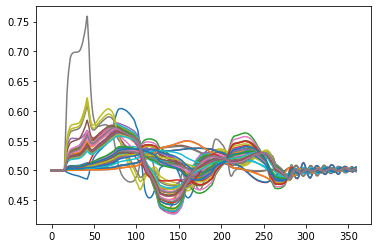

In [ ]:
for i in dataset_CC[100][0]:
    plt.plot(i)

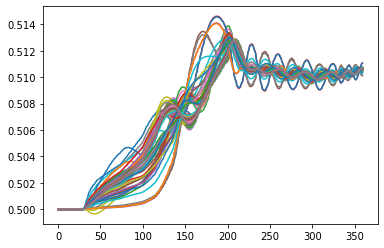

In [ ]:
len(dataset_LL[100][0])

for i in dataset_LL[100][0]:
    plt.plot(i)

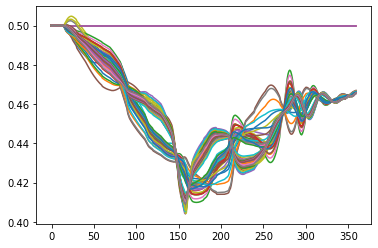

In [ ]:
len(dataset_GL[100][0])

for i in dataset_GL[100][0]:
    plt.plot(i)

In [ ]:
CC_torch, GL_torch, LL_torch = [], [], []

for itemCC in dataset_CC:
    CC_torch.append(transform_signal(itemCC[0], inteiro=True, show=False, corrigir=True, random=False, channels=3, dobro=False))

for itemGL in dataset_GL:
    GL_torch.append(transform_signal(itemGL[0], inteiro=True, show=False, corrigir=True, random=False, channels=3, dobro=False))

for itemLL in dataset_LL:
    LL_torch.append(transform_signal(itemLL[0], inteiro=True, show=False, corrigir=True, random=False, channels=3, dobro=False))

CC_torch = torch.tensor(CC_torch)
GL_torch = torch.tensor(GL_torch)
LL_torch = torch.tensor(LL_torch)

complete_set = []
train_set, valid_set = [], []
train_size = 300

for counter, value in enumerate(CC_torch):
    imagem = (value, 0)
    complete_set.append(imagem)

    if counter < train_size:
        train_set.append(imagem)
    else:
        valid_set.append(imagem)

for counter, value in enumerate(GL_torch):
    imagem = (value, 1)
    complete_set.append(imagem)

    if counter < train_size:
        train_set.append(imagem)
    else:
        valid_set.append(imagem)

for counter, value in enumerate(LL_torch):
    imagem = (value, 2)
    complete_set.append(imagem)

    if counter < train_size:
        train_set.append(imagem)
    else:
        valid_set.append(imagem)

print(f'Shape:      {complete_set[0][0].shape}')
print(f'Train Size: {len(train_set)}')
print(f'Valid Size: {len(valid_set)}\n')
print(f'Relação de treino/validação: {100*len(train_set)/len(valid_set) : .2f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  if sys.path[0] == '':


Shape:      torch.Size([3, 23, 360])
Train Size: 900
Valid Size: 2010

Relação de treino/validação:  44.78


## Model

### Double Conv

In [ ]:
# Define model of double convolution

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        self.conv = nn.Sequential(
        
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        
        )
        
    def forward(self, x):
        return self.conv(x)

### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, features=[64, 128, 256, 512]):
        super(Encoder, self).__init__()
        
        self.downs = nn.ModuleList()
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        
        
    def forward(self, x):

        self.skip_connections = []
        
        for down in self.downs:
            x = down(x)
            self.skip_connections.append(x)
            x = self.pool(x)
        
        return x

In [ ]:
class EncoderFC(nn.Module):
    def __init__(self, features=512):
        super(EncoderFC, self).__init__()

        self.features = features

        self.fci1  = nn.Sequential(nn.Linear(features*1*22, features*2),
                                   nn.ReLU(),
                                   nn.Linear(features*2, features),
                                   nn.ReLU(),
                                   nn.Linear(features, 1024))
        
        
        
    def forward(self, x, s):

        x = x.reshape(s, -1)

        x = self.fci1(x)
        
        return x

In [ ]:
class DecoderFC(nn.Module):
    def __init__(self, features=512):
        super(DecoderFC, self).__init__()

        self.features = features
        self.fci2 = nn.Sequential(nn.Linear(1024, features*2),
                                  nn.ReLU(),
                                  nn.Linear(features*2, features*1*22),
                                  nn.ReLU())
        
        
        
    def forward(self, x, s):

        x = self.fci2(x)

        x = x.reshape(s, self.features, 1, 22)
        
        return x

### UNet

In [ ]:
class Classificador(nn.Module):
    def __init__(self, unet):
        super(UNet, self).__init__()

        self.unet = unet

        self.mlp = nn.dsbf

    def forward(x):

      x = self.unet.encoder(x)
      x = torch.mean(x, dim = (-2, -1))
      x = self.mlp(x)

      return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super(UNet, self).__init__()
        
        self.encoder = Encoder(in_channels, features)
        self.ups     = nn.ModuleList()

        # self.fce     = EncoderFC(512)
        # self.fcd     = DecoderFC(512)
        
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
        
        
    def forward(self, x):

        self.decoder_skip_connections = []
        
        x = self.encoder(x)

        # s = x.shape[0]
        # x = self.fce(x, s)
        # x = self.fcd(x, s)
        
        x = self.bottleneck(x)
        
        self.decoder_skip_connections.append(x)

        
        self.encoder_skip_connections = self.encoder.skip_connections[::-1]
        
        for i in range(0, len(self.ups), 2):
            
            x = self.ups[i](x)
            
            self.decoder_skip_connections.append(x)
        
            skip_connection = self.encoder_skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            
            x = self.ups[i+1](concat_skip)
        
        return self.final_conv(x)

## Treino

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = UNet(3, 3, [64])

device = get_device()
# print(device)
model = model.to(device)

In [ ]:
args = {'batch_size'          : 8,
        'lr'                  : 0.01,
        'weight_decay'        : 0.0,
        'n_epochs'            : 100,
        'momentum'            : 0.9,
        'scheduler_step_size' : 15,
        'scheduler_gamma'     : 0.1
        }

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

In [ ]:
ts = CustomDataset(train_set)
vs = CustomDataset(valid_set)

train_loader = torch.utils.data.DataLoader(ts, batch_size=args['batch_size'], num_workers=0, shuffle=True)
valid_loader = torch.utils.data.DataLoader(vs, batch_size=args['batch_size'], num_workers=0, shuffle=False)

In [ ]:
criterion = nn.L1Loss().to(device)
# criterion = nn.MSELoss().to(device)
# criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay']) # 5h33

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_train_per_epoch = [], []
loss_per_epoch_valid, cluster_precision_valid_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    model.train()

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)      

    valid_loss = check_accuracy(valid_loader, model)
    loss_per_epoch_valid.append(valid_loss)

    cluster_result_train = cluster_test(train_set, model) 
    cluster_precision_train = precision_matrix(cluster_result_train)
    cluster_precision_train_per_epoch.append(cluster_precision_train)

    cluster_result_valid = cluster_test(valid_set, model) 
    cluster_precision_valid = precision_matrix(cluster_result_valid)
    cluster_precision_valid_per_epoch.append(cluster_precision_valid)

    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(f'Cluster Train: {cluster_result_train}')
        print(f'Cluster Valid: {cluster_result_valid}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\t\tValidation Loss: {valid_loss :.6f}') 
        print(f'Cluster Precision Train: {cluster_precision_train:.4}\t\tCluster Precision Valid: {cluster_precision_valid:.4}\n')
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(f'Cluster Train: {cluster_result_train}')
        print(f'Cluster Valid: {cluster_result_valid}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\t\tValidation Loss: {valid_loss :.6f}') 
        print(f'Cluster Precision Train: {cluster_precision_train:.4}\t\tCluster Precision Valid: {cluster_precision_valid:.4}\n')


plt.plot(cluster_precision_train_per_epoch, label='Train')
plt.plot(cluster_precision_valid_per_epoch, label='Valid')
plt.show()

plt.plot(loss_per_epoch_train, label='Train')
plt.plot(loss_per_epoch_valid, label='Valid')
plt.show()

Epoch 1 ===================================================================================

Cluster Train: [[0, 4, 296], [299, 0, 1], [1, 298, 1]]
Cluster Valid: [[0, 663, 7], [663, 7, 0], [1, 4, 665]]

Training Loss: 1.117779			Validation Loss: 0.598843
Cluster Precision Train: 99.22		Cluster Precision Valid: 99.05

Epoch 2 ===================================================================================

Cluster Train: [[0, 296, 4], [298, 2, 0], [1, 1, 298]]
Cluster Valid: [[7, 0, 663], [0, 662, 8], [665, 1, 4]]

Training Loss: 0.602229			Validation Loss: 0.362912
Cluster Precision Train: 99.11		Cluster Precision Valid: 99.0

Epoch 3 ===================================================================================

Cluster Train: [[4, 0, 296], [0, 299, 1], [298, 1, 1]]
Cluster Valid: [[663, 0, 7], [7, 663, 0], [4, 1, 665]]

Training Loss: 0.506839			Validation Loss: 0.306261
Cluster Precision Train: 99.22		Cluster Precision Valid: 99.05

Epoch 4 =================================

KeyboardInterrupt: ignored

Epoch 1 ===================================================================================

Cluster Train: [[2, 0, 298], [0, 292, 8], [291, 0, 9]]
Cluster Valid: [[0, 0, 670], [665, 0, 5], [1, 627, 42]]

Training Loss: 0.940737			Validation Loss: 0.542918
Cluster Precision Train: 97.89		Cluster Precision Valid: 97.61

Epoch 2 ===================================================================================

Cluster Train: [[0, 2, 298], [296, 0, 4], [0, 289, 11]]
Cluster Valid: [[0, 670, 0], [0, 6, 664], [628, 41, 1]]

Training Loss: 0.602740			Validation Loss: 0.378586
Cluster Precision Train: 98.11		Cluster Precision Valid: 97.61

Epoch 3 ===================================================================================

Cluster Train: [[2, 0, 298], [0, 293, 7], [288, 0, 12]]
Cluster Valid: [[0, 0, 670], [0, 664, 6], [628, 0, 42]]

Training Loss: 0.497378			Validation Loss: 0.304353
Cluster Precision Train: 97.67		Cluster Precision Valid: 97.61

Epoch 4 ===========================

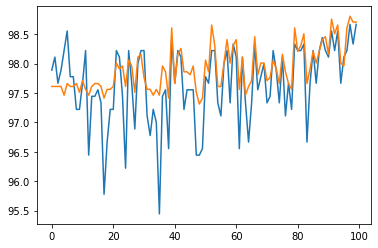

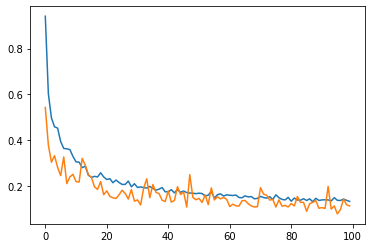

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_train_per_epoch = [], []
loss_per_epoch_valid, cluster_precision_valid_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    model.train()

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)      

    valid_loss = check_accuracy(valid_loader, model)
    loss_per_epoch_valid.append(valid_loss)

    cluster_result_train = cluster_test(train_set, model) 
    cluster_precision_train = precision_matrix(cluster_result_train)
    cluster_precision_train_per_epoch.append(cluster_precision_train)

    cluster_result_valid = cluster_test(valid_set, model) 
    cluster_precision_valid = precision_matrix(cluster_result_valid)
    cluster_precision_valid_per_epoch.append(cluster_precision_valid)

    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(f'Cluster Train: {cluster_result_train}')
        print(f'Cluster Valid: {cluster_result_valid}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\t\tValidation Loss: {valid_loss :.6f}') 
        print(f'Cluster Precision Train: {cluster_precision_train:.4}\t\tCluster Precision Valid: {cluster_precision_valid:.4}\n')
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(f'Cluster Train: {cluster_result_train}')
        print(f'Cluster Valid: {cluster_result_valid}')
        print(f'\nTraining Loss: {train_loss:.6f}\t\t\tValidation Loss: {valid_loss :.6f}') 
        print(f'Cluster Precision Train: {cluster_precision_train:.4}\t\tCluster Precision Valid: {cluster_precision_valid:.4}\n')


plt.plot(cluster_precision_train_per_epoch, label='Train')
plt.plot(cluster_precision_valid_per_epoch, label='Valid')
plt.show()

plt.plot(loss_per_epoch_train, label='Train')
plt.plot(loss_per_epoch_valid, label='Valid')
plt.show()

Epoch 1 ===================================================================================

[[0, 0, 970], [964, 0, 6], [2, 942, 26]]

Training Loss: 0.740502		Cluster Precision: 98.83

Epoch 2 ===================================================================================

[[0, 968, 2], [968, 2, 0], [2, 2, 966]]

Training Loss: 0.306777		Cluster Precision: 99.73

Epoch 3 ===================================================================================

[[1, 0, 969], [0, 968, 2], [958, 2, 10]]

Training Loss: 0.207450		Cluster Precision: 99.48

Epoch 4 ===================================================================================

[[0, 2, 968], [967, 0, 3], [2, 966, 2]]

Training Loss: 0.180845		Cluster Precision: 99.69

Epoch 5 ===================================================================================

[[2, 0, 968], [0, 966, 4], [961, 2, 7]]

Training Loss: 0.162191		Cluster Precision: 99.48

Epoch 6 =================================================================

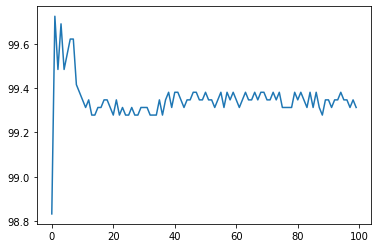

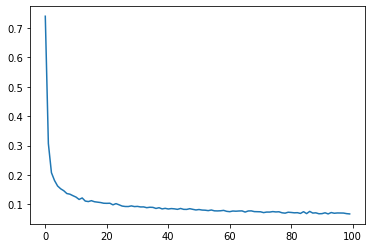

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)      

    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)


    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(cluster_result)
        print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE_v1/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(cluster_result)
        print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

plt.plot(cluster_precision_per_epoch)
plt.show()

plt.plot(loss_per_epoch_train)
plt.show()

Epoch 1 ===================================================================================

[[1454, 0, 6], [32, 940, 488], [24, 0, 1436]]

Training Loss: 0.612621		Cluster Precision: 87.44

Epoch 2 ===================================================================================

[[40, 0, 1420], [494, 958, 8], [1455, 0, 5]]

Training Loss: 0.287170		Cluster Precision: 87.51

Epoch 3 ===================================================================================

[[25, 1435, 0], [494, 10, 956], [1455, 5, 0]]

Training Loss: 0.197629		Cluster Precision: 87.81

Epoch 4 ===================================================================================

[[1446, 0, 14], [10, 956, 494], [5, 0, 1455]]

Training Loss: 0.171448		Cluster Precision: 88.06

Epoch 5 ===================================================================================

[[1448, 0, 12], [13, 953, 494], [5, 0, 1455]]

Training Loss: 0.161497		Cluster Precision: 88.04

Epoch 6 ======================================

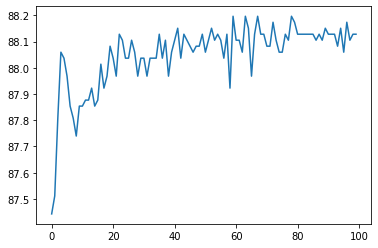

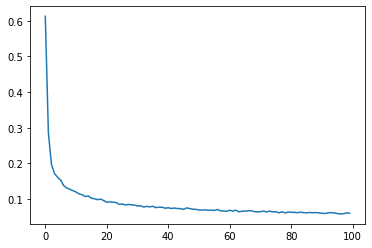

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)      

    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)


    
    if epoch % 10 == 0:
        print(f'Epoch {epoch} =================================================================================== <- SAVE\n')
        print(cluster_result)
        print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))
        torch.save(model.state_dict(), '/content/drive/MyDrive/Guilherme/MODEL_SAVE/AE_' + str(epoch) + '.pth.tar')
    else:
        print(f'Epoch {epoch} ===================================================================================\n')
        print(cluster_result)
        print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

plt.plot(cluster_precision_per_epoch)
plt.show()

plt.plot(loss_per_epoch_train)
plt.show()

## Teste DF

In [ ]:
j = 0
labels = []

for i in range(len(complete_set)):
    labels.append([j, complete_set[i][1]])
    j += 1

In [ ]:
len(labels)

4380

In [ ]:
import pandas as pd

df_events = pd.DataFrame(labels, columns=['index', 'label'])
df_events['nome'] = nomes
df_events['pred'] = labels_pred

df_events.head()

,index,label,nome,pred
0,0,0,CC-3500-100-12.csv,2
1,1,0,CC-3500-100-11.csv,2
2,2,0,CC-3500-100-1.csv,2
3,3,0,CC-3500-100-13.csv,2
4,4,0,CC-3500-100-19.csv,2


In [ ]:
label_1 = df_events.loc[df_events['label'] == 1]
label_1.loc[df_events['pred'] == 1].head()

,index,label,nome,pred
1963,1963,1,LL-95-20-21.csv,1
1965,1965,1,LL-95-20-23.csv,1
1966,1966,1,LL-95-20-24.csv,1
1967,1967,1,LL-95-20-36.csv,1
1968,1968,1,LL-95-20-26.csv,1


In [ ]:
labels_pred, cluster_result = cluster_test(complete_set, model)
cluster_result

[[0, 0, 1460], [952, 485, 23], [3, 1427, 30]]

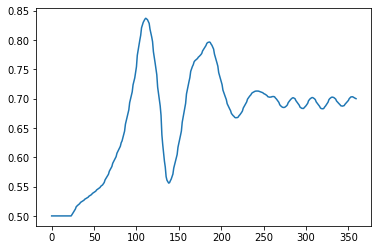

In [ ]:
plt.plot(teste[0])

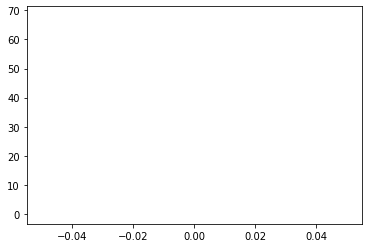

In [ ]:
teste = []
for i in range(3):
    for j in range(23):
        teste.append(complete_set[1963][0][i][j])

for i in range(len(teste)):
    plt.plot(i)
plt.show()

## Testes

### Teste 20

batch_size = 8 <br>
Network    = [64, 128, 256, 512] <br>
LR         = 0.01 <br>
weight_dec = 0.0 <br>
canais     = 3 <br>
<br>
Descrição  = 3 camadas (68, 360), mantendo o 0.5 e a proporção

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1454, 0, 6], [14, 954, 492], [8, 3, 1449]]

Training Loss: 0.147051		Cluster Precision: 88.06

Epoch 2 ===================================================================================

[[6, 0, 1454], [491, 947, 22], [1446, 0, 14]]

Training Loss: 0.079475		Cluster Precision: 87.83

Epoch 3 ===================================================================================

[[0, 1454, 6], [952, 23, 485], [0, 32, 1428]]

Training Loss: 0.066922		Cluster Precision: 87.53



KeyboardInterrupt: ignored

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste 19

batch_size = 8 <br>
Network    = [64, 128, 256, 512] <br>
LR         = 0.01 <br>
weight_dec = 0.0 <br>
canais     = 3 <br>
<br>
Descrição  = 3 camadas (68, 360), mantendo o 0.5

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1460, 0, 0], [506, 807, 147], [1460, 0, 0]]

Training Loss: 0.597966		Cluster Precision: 51.76

Epoch 2 ===================================================================================

[[1460, 0, 0], [500, 812, 148], [1460, 0, 0]]

Training Loss: 0.372346		Cluster Precision: 51.87

Epoch 3 ===================================================================================

[[0, 1460, 0], [908, 140, 412], [0, 252, 1208]]

Training Loss: 0.320199		Cluster Precision: 81.64

Epoch 4 ===================================================================================

[[1458, 2, 0], [141, 413, 906], [249, 1211, 0]]

Training Loss: 0.292962		Cluster Precision: 81.62

Epoch 5 ===================================================================================

[[0, 1460, 0], [412, 128, 920], [1209, 251, 0]]

Training Loss: 0.269123		Cluster Precision: 81.94

Epoch 6 ===============================

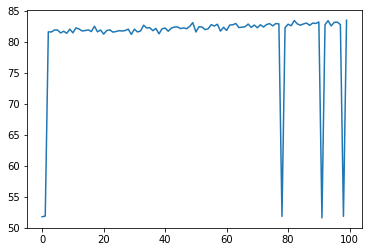

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

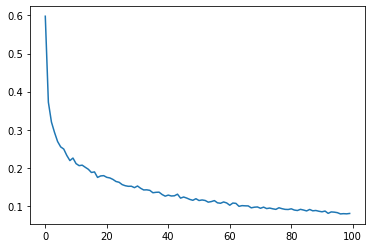

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste 18

batch_size = 8 <br>
Network    = [64, 128, 256, 512] <br>
LR         = 0.01 <br>
weight_dec = 0.0 <br>
canais     = 3 <br>
<br>
Descrição  = 3 camadas (23, 360), meio em 0, variando [-1, 1]


In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[138, 0, 1322], [503, 143, 814], [1438, 0, 22]]

Training Loss: 0.841052		Cluster Precision: 66.28

Epoch 2 ===================================================================================

[[146, 1314, 0], [509, 811, 140], [1447, 13, 0]]

Training Loss: 0.635161		Cluster Precision: 66.23

Epoch 3 ===================================================================================

[[1317, 143, 0], [810, 510, 140], [12, 1448, 0]]

Training Loss: 0.524725		Cluster Precision: 66.32

Epoch 4 ===================================================================================

[[0, 1322, 138], [143, 811, 506], [0, 13, 1447]]

Training Loss: 0.481640		Cluster Precision: 66.48

Epoch 5 ===================================================================================

[[0, 1326, 134], [136, 811, 513], [0, 12, 1448]]

Training Loss: 0.446651		Cluster Precision: 66.44

Epoch 6 ======================

KeyboardInterrupt: ignored

### Teste 17

batch_size = 8 <br>
Network    = [64, 128, 256, 512] <br>
LR         = 0.01 <br>
weight_dec = 0.0 <br>
canais     = 3 <br>
<br>
Descrição  = 3 camadas (23, 360) e mantendo o 0.5


In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1460, 0, 0], [509, 807, 144], [1460, 0, 0]]

Training Loss: 0.618129		Cluster Precision: 51.76

Epoch 2 ===================================================================================

[[1460, 0, 0], [54, 480, 926], [48, 1412, 0]]

Training Loss: 0.349267		Cluster Precision: 86.71

Epoch 3 ===================================================================================

[[1460, 0, 0], [78, 904, 478], [52, 0, 1408]]

Training Loss: 0.283464		Cluster Precision: 86.12

Epoch 4 ===================================================================================

[[0, 0, 1460], [479, 914, 67], [1409, 0, 51]]

Training Loss: 0.252911		Cluster Precision: 86.37

Epoch 5 ===================================================================================

[[1460, 0, 0], [61, 924, 475], [57, 0, 1403]]

Training Loss: 0.231606		Cluster Precision: 86.46

Epoch 6 =====================================

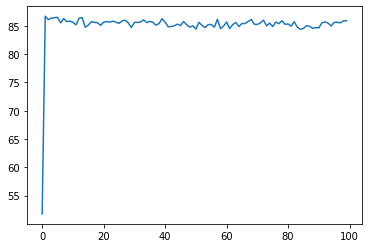

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

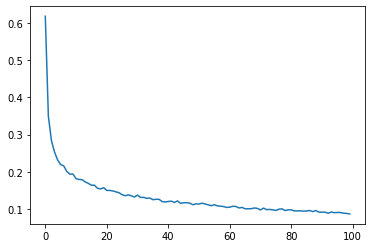

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste16

batch=8 <br>
[64, 128, 256, 512] <br>
random=False <br>
desc: 3 camadas, mas sobrepostas sem divisão e depois sem divisao, corrigido <br>

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)
ts = CustomDataset(teste_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)
train_loader1 = torch.utils.data.DataLoader(ts, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch, cluster_precision_per_epoch1 = [], [], []

for epoch in range(1, n_epochs+1):
    
    print(f'Epoch {epoch} ==============================================================================================================\n')
    print('Treino Completo\n')
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()          
        # Forward
        outputs = model(images)
        loss = criterion(outputs.float(), images.float())
        #Backward        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(teste_set, model)   
    cluster_result1 = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    cluster_precision1 = precision_matrix(cluster_result1)
    cluster_precision_per_epoch1.append(cluster_precision1)

    
    print(f'Teste:    {cluster_result}')
    print(f'Complete: {cluster_result1}')
    print('\nTraining Loss: {:.6f}\t\tCluster Precision Teste: {:.4}\t\tCluster Precision Completo: {:.4}\n'.format(train_loss, cluster_precision, cluster_precision1))
    print('Treino Teste\n')
    for data in train_loader1:

        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()          
        # Forward
        outputs = model(images)
        loss = criterion(outputs.float(), images.float())
        #Backward        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(teste_set, model)   
    cluster_result1 = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    cluster_precision1 = precision_matrix(cluster_result1)
    cluster_precision_per_epoch1.append(cluster_precision1)

    
    print(f'Teste:    {cluster_result}')
    print(f'Complete: {cluster_result1}')
    print('\nTraining Loss: {:.6f}\t\tCluster Precision Teste: {:.4}\t\tCluster Precision Completo: {:.4}\n'.format(train_loss, cluster_precision, cluster_precision1))

Epoch 1 ==============================================================================================================

Treino Completo

Teste:    [[1290, 3, 167], [4, 878, 578], [12, 0, 1448]]
Complete: [[1460, 0, 0], [196, 864, 400], [335, 0, 1125]]

Training Loss: 0.545737		Cluster Precision Teste: 82.56		Cluster Precision Completo: 78.74

Treino Teste

Teste:    [[60, 1395, 5], [508, 51, 901], [1327, 128, 5]]
Complete: [[1460, 0, 0], [208, 838, 414], [299, 0, 1161]]

Training Loss: 0.251766		Cluster Precision Teste: 82.72		Cluster Precision Completo: 78.97

Epoch 2 ==============================================================================================================

Treino Completo

Teste:    [[1373, 84, 3], [40, 534, 886], [103, 1354, 3]]
Complete: [[0, 0, 1460], [419, 866, 175], [1147, 0, 313]]

Training Loss: 0.332498		Cluster Precision Teste: 82.49		Cluster Precision Completo: 79.29

Treino Teste

Teste:    [[14, 1427, 19], [459, 56, 945], [1237, 156, 67]]
Complete: [[

KeyboardInterrupt: ignored

### Teste15

batch=8 <br>
[64, 128, 256, 512] <br>
random=False <br>
desc: 3 camadas, mas sobrepostas com divisão, corrigido, invertido <br>

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

### Teste14

batch=8 <br>
[64, 128, 256, 512] <br>
random=False <br>
desc: 3 camadas, mas sobrepostas com divisão, corrigido, variando entre -1 e 1 <br>

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

### Teste13

batch=8 <br>
[64, 128, 256, 512] <br>
random=False <br>
desc: 3 camadas, mas sobrepostas com divisão, corrigido - analise com 3 camadas, mas sobrepostas sem divisão<br>

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch, cluster_precision_per_epoch1 = [], [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(teste_set, model)   
    cluster_result1 = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    cluster_precision1 = precision_matrix(cluster_result1)
    cluster_precision_per_epoch1.append(cluster_precision1)

    print(f'Epoch {epoch} ==============================================================================================================\n')
    print(f'Teste:    {cluster_result}')
    print(f'Complete: {cluster_result1}')
    print('\nTraining Loss: {:.6f}\t\tCluster Precision Teste: {:.4}\t\tCluster Precision Completo: {:.4}\n'.format(train_loss, cluster_precision, cluster_precision1))

Epoch 1 ==============================================================================================================

Teste:    [[211, 0, 1249], [584, 865, 11], [1440, 0, 20]]
Complete: [[0, 0, 1460], [349, 806, 305], [1027, 0, 433]]

Training Loss: 0.547594		Cluster Precision Teste: 81.14		Cluster Precision Completo: 75.18

Epoch 2 ==============================================================================================================

Teste:    [[1282, 0, 178], [20, 855, 585], [33, 1, 1426]]
Complete: [[1397, 0, 63], [47, 822, 591], [3, 2, 1455]]

Training Loss: 0.328452		Cluster Precision Teste: 81.35		Cluster Precision Completo: 83.88

Epoch 3 ==============================================================================================================

Teste:    [[184, 0, 1276], [588, 853, 19], [1429, 0, 31]]
Complete: [[65, 0, 1395], [597, 819, 44], [1448, 9, 3]]

Training Loss: 0.288230		Cluster Precision Teste: 81.23		Cluster Precision Completo: 83.61

Epoch 4 =========

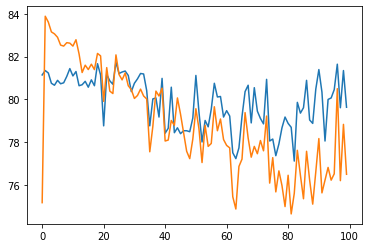

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.plot(cluster_precision_per_epoch1)
plt.show()

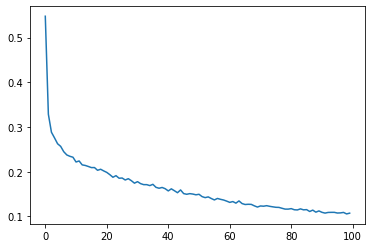

In [ ]:
plt.plot(loss_per_epoch_train)

### Teste12

batch=8 <br>
[64, 128, 256, 512] <br>
random=False <br>
desc: 3 camadas, mas sobrepostas sem divisão, corrigido <br>

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_precision = precision_matrix(cluster_result)
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1186, 249, 25], [297, 329, 834], [867, 593, 0]]

Training Loss: 0.527811		Cluster Precision: 59.66

Epoch 2 ===================================================================================

[[242, 27, 1191], [338, 836, 286], [623, 0, 837]]

Training Loss: 0.326237		Cluster Precision: 60.5

Epoch 3 ===================================================================================

[[1194, 25, 241], [274, 832, 354], [807, 0, 653]]

Training Loss: 0.309191		Cluster Precision: 61.16

Epoch 4 ===================================================================================

[[1205, 22, 233], [271, 828, 361], [797, 0, 663]]

Training Loss: 0.289492		Cluster Precision: 61.55

Epoch 5 ===================================================================================

[[16, 1238, 206], [822, 271, 367], [0, 780, 680]]

Training Loss: 0.277113		Cluster Precision: 62.56

Epoch 6 ==================

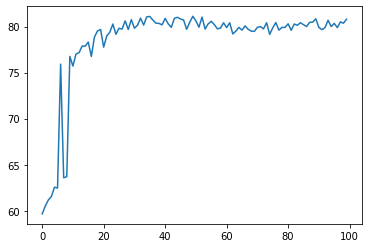

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

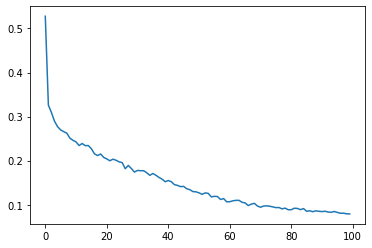

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste11

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[338, 0, 1122], [370, 795, 295], [619, 0, 841]]

Training Loss: 0.582382		Cluster Precision: 62.97



In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste10



In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1409, 0, 51], [128, 806, 526], [209, 0, 1251]]

Training Loss: 0.562118		Cluster Precision: 79.13

Epoch 2 ===================================================================================

[[77, 1383, 0], [656, 45, 759], [1456, 4, 0]]

Training Loss: 0.331657		Cluster Precision: 82.15

Epoch 3 ===================================================================================

[[77, 1383, 0], [660, 50, 750], [1455, 5, 0]]

Training Loss: 0.305033		Cluster Precision: 81.92

Epoch 4 ===================================================================================

[[1383, 77, 0], [45, 667, 748], [4, 1456, 0]]

Training Loss: 0.285956		Cluster Precision: 81.89

Epoch 5 ===================================================================================

[[1387, 0, 73], [43, 755, 662], [4, 0, 1456]]

Training Loss: 0.268474		Cluster Precision: 82.15

Epoch 6 ==================================

KeyboardInterrupt: ignored

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste9

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[0, 87, 1373], [861, 592, 7], [0, 1457, 3]]

Training Loss: 0.495482		Cluster Precision: 84.27

Epoch 2 ===================================================================================

[[84, 0, 1376], [593, 857, 10], [1457, 0, 3]]

Training Loss: 0.315848		Cluster Precision: 84.25

Epoch 3 ===================================================================================

[[82, 0, 1378], [605, 845, 10], [1457, 0, 3]]

Training Loss: 0.296080		Cluster Precision: 84.02

Epoch 4 ===================================================================================

[[1371, 0, 89], [10, 845, 605], [3, 0, 1457]]

Training Loss: 0.288807		Cluster Precision: 83.86

Epoch 5 ===================================================================================

[[1370, 0, 90], [10, 838, 612], [3, 0, 1457]]

Training Loss: 0.281953		Cluster Precision: 83.68

Epoch 6 ======================================

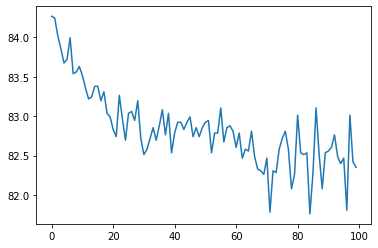

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

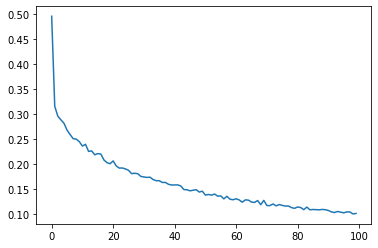

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste8

In [ ]:
rs = CustomDataset(random_complete_set)
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(rs, batch_size=args['batch_size'], num_workers=0, shuffle=True)
valid_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=False)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1460, 0, 0], [227, 881, 352], [442, 0, 1018]]

Training Loss: 12.184907		Cluster Precision: 76.69

Epoch 2 ===================================================================================

[[0, 1460, 0], [880, 224, 356], [0, 430, 1030]]

Training Loss: 4.606156		Cluster Precision: 76.94

Epoch 3 ===================================================================================

[[0, 0, 1460], [365, 881, 214], [1054, 0, 406]]

Training Loss: 3.706583		Cluster Precision: 77.51

Epoch 4 ===================================================================================

[[1460, 0, 0], [208, 881, 371], [397, 0, 1063]]

Training Loss: 3.242613		Cluster Precision: 77.72

Epoch 5 ===================================================================================

[[0, 0, 1460], [373, 883, 204], [1065, 0, 395]]

Training Loss: 2.970638		Cluster Precision: 77.81

Epoch 6 ==========================

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste7

3D, batch=8, [256, 512, 1024, 2048]

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[677, 0, 783], [345, 787, 328], [990, 0, 470]]

Training Loss: 0.578854		Cluster Precision: 58.45

Epoch 2 ===================================================================================

[[0, 69, 1391], [825, 618, 17], [0, 1457, 3]]

Training Loss: 0.442615		Cluster Precision: 83.86

Epoch 3 ===================================================================================

[[1387, 0, 73], [17, 829, 614], [3, 0, 1457]]

Training Loss: 0.402032		Cluster Precision: 83.86

Epoch 4 ===================================================================================

[[1389, 71, 0], [16, 618, 826], [3, 1457, 0]]

Training Loss: 0.396363		Cluster Precision: 83.84

Epoch 5 ===================================================================================

[[1387, 0, 73], [16, 827, 617], [3, 0, 1457]]

Training Loss: 0.361992		Cluster Precision: 83.81

Epoch 6 ===================================

KeyboardInterrupt: ignored

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste6

3D, batch=64, [8, 16, 32,64]

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[55, 734, 671], [670, 432, 358], [15, 468, 977]]

Training Loss: 24.289379		Cluster Precision: 54.36

Epoch 2 ===================================================================================

[[697, 66, 697], [511, 602, 347], [504, 21, 935]]

Training Loss: 12.354226		Cluster Precision: 51.0

Epoch 3 ===================================================================================

[[800, 565, 95], [571, 355, 534], [545, 891, 24]]

Training Loss: 7.201721		Cluster Precision: 51.64

Epoch 4 ===================================================================================

[[516, 834, 110], [389, 584, 487], [909, 527, 24]]

Training Loss: 5.941466		Cluster Precision: 53.13

Epoch 5 ===================================================================================

[[445, 888, 127], [416, 562, 482], [907, 529, 24]]

Training Loss: 5.449028		Cluster Precision: 53.81

Epoch 6 ==============

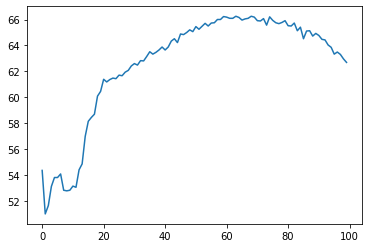

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

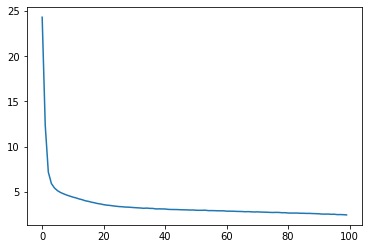

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste5

3D, batch=8, [8, 16, 32, 64]

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[951, 0, 509], [148, 927, 385], [347, 11, 1102]]

Training Loss: 1.145311		Cluster Precision: 68.04

Epoch 2 ===================================================================================

[[1450, 1, 9], [111, 389, 960], [255, 1143, 62]]

Training Loss: 0.579687		Cluster Precision: 81.12

Epoch 3 ===================================================================================

[[993, 20, 447], [221, 414, 825], [3, 1176, 281]]

Training Loss: 0.526210		Cluster Precision: 68.36

Epoch 4 ===================================================================================

[[1106, 15, 339], [46, 1125, 289], [0, 688, 772]]

Training Loss: 0.496579		Cluster Precision: 68.56

Epoch 5 ===================================================================================

[[395, 24, 1041], [452, 930, 78], [409, 1031, 20]]

Training Loss: 0.479627		Cluster Precision: 68.54

Epoch 6 =================

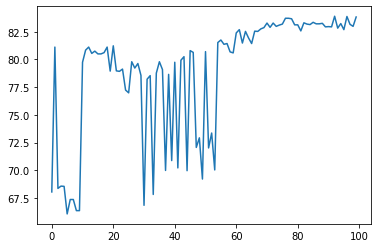

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

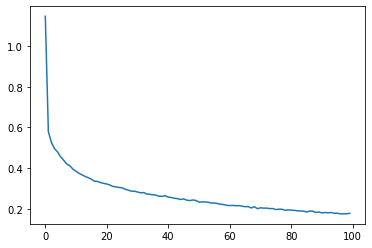

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste4

3D, batch = 100

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[6, 1454, 0], [472, 98, 890], [1291, 169, 0]]

Training Loss: 15.434721		Cluster Precision: 82.99

Epoch 2 ===================================================================================

[[6, 0, 1454], [513, 860, 87], [1261, 0, 199]]

Training Loss: 5.736714		Cluster Precision: 81.62

Epoch 3 ===================================================================================

[[1453, 0, 7], [83, 859, 518], [193, 0, 1267]]

Training Loss: 4.610698		Cluster Precision: 81.71

Epoch 4 ===================================================================================

[[7, 0, 1453], [522, 859, 79], [1275, 0, 185]]

Training Loss: 4.044210		Cluster Precision: 81.89

Epoch 5 ===================================================================================

[[1453, 7, 0], [83, 517, 860], [191, 1269, 0]]

Training Loss: 3.709761		Cluster Precision: 81.78

Epoch 6 ===============================

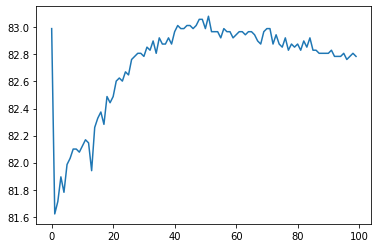

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

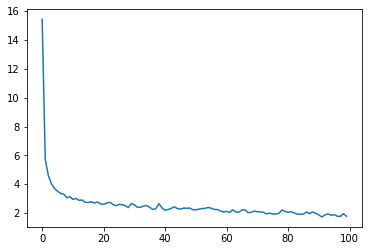

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste3

1D, batch = 8

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1201, 1, 258], [11, 890, 559], [30, 0, 1430]]

Training Loss: 0.524650		Cluster Precision: 80.39

Epoch 2 ===================================================================================

[[252, 0, 1208], [561, 887, 12], [1428, 0, 32]]

Training Loss: 0.392489		Cluster Precision: 80.43

Epoch 3 ===================================================================================

[[1208, 0, 252], [12, 880, 568], [32, 0, 1428]]

Training Loss: 0.361230		Cluster Precision: 80.27

Epoch 4 ===================================================================================

[[253, 0, 1207], [570, 878, 12], [1425, 0, 35]]

Training Loss: 0.350088		Cluster Precision: 80.14

Epoch 5 ===================================================================================

[[246, 0, 1214], [570, 878, 12], [1425, 0, 35]]

Training Loss: 0.341595		Cluster Precision: 80.3

Epoch 6 ============================

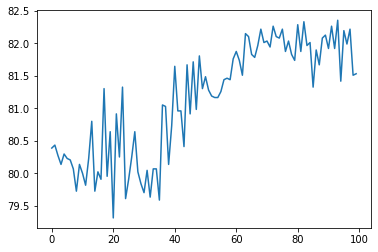

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

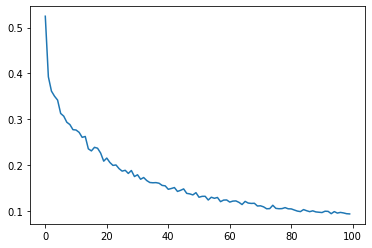

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste2

3D, batch = 64

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1460, 0, 0], [163, 865, 432], [241, 0, 1219]]

Training Loss: 9.854082		Cluster Precision: 80.91

Epoch 2 ===================================================================================

[[1460, 0, 0], [186, 846, 428], [240, 0, 1220]]

Training Loss: 3.592833		Cluster Precision: 80.5

Epoch 3 ===================================================================================

[[1460, 0, 0], [148, 862, 450], [228, 0, 1232]]

Training Loss: 2.857398		Cluster Precision: 81.14

Epoch 4 ===================================================================================

[[1460, 0, 0], [135, 861, 464], [215, 0, 1245]]

Training Loss: 2.479939		Cluster Precision: 81.42

Epoch 5 ===================================================================================

[[1460, 0, 0], [113, 864, 483], [196, 0, 1264]]

Training Loss: 2.260029		Cluster Precision: 81.92

Epoch 6 ============================

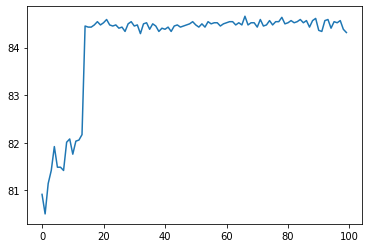

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

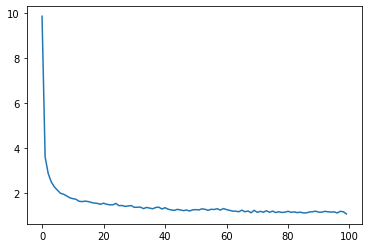

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

### Teste1

3D, batch = 8

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1074, 59, 327], [18, 424, 1018], [0, 1143, 317]]

Training Loss: 0.561261		Cluster Precision: 73.86

Epoch 2 ===================================================================================

[[1095, 309, 56], [21, 1020, 419], [0, 332, 1128]]

Training Loss: 0.329546		Cluster Precision: 74.04

Epoch 3 ===================================================================================

[[10, 96, 1354], [889, 549, 22], [21, 1439, 0]]

Training Loss: 0.290920		Cluster Precision: 84.06

Epoch 4 ===================================================================================

[[1206, 56, 198], [25, 432, 1003], [1, 1158, 301]]

Training Loss: 0.288995		Cluster Precision: 76.87

Epoch 5 ===================================================================================

[[0, 1370, 90], [884, 22, 554], [19, 0, 1441]]

Training Loss: 0.273719		Cluster Precision: 84.36

Epoch 6 ===================

In [ ]:
cs = CustomDataset(complete_set)

train_loader = torch.utils.data.DataLoader(cs, batch_size=args['batch_size'], num_workers=0, shuffle=True)

n_epochs = args['n_epochs']
loss_per_epoch_train, cluster_precision_per_epoch = [], []

for epoch in range(1, n_epochs+1):
      
    # monitor training loss
    train_loss = 0.0

    #Training

    model.train()

    for data in train_loader:

            
        images, _, _ = data
        images    = images.to(device).float()
        optimizer.zero_grad()  
        
        # Forward

        outputs = model(images)
        loss = criterion(outputs.float(), images.float())

        #Backward
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    loss_per_epoch_train.append(train_loss)
    
    
    cluster_result = cluster_test(complete_set, model)   

    cluster_result_np = np.asarray(cluster_result)
    cluster_precision = ((np.max(cluster_result_np, 1).sum())/(3*1460))*100
    cluster_precision_per_epoch.append(cluster_precision)

    print(f'Epoch {epoch} ===================================================================================\n')
    print(cluster_result)
    print('\nTraining Loss: {:.6f}\t\tCluster Precision: {:.4}\n'.format(train_loss, cluster_precision))

Epoch 1 ===================================================================================

[[1400, 60, 0], [13, 575, 872], [0, 1460, 0]]

Training Loss: 0.525615		Cluster Precision: 85.21

Epoch 2 ===================================================================================

[[1400, 0, 60], [13, 877, 570], [0, 1, 1459]]

Training Loss: 0.318767		Cluster Precision: 85.3

Epoch 3 ===================================================================================

[[1401, 59, 0], [14, 567, 879], [0, 1460, 0]]

Training Loss: 0.298094		Cluster Precision: 85.39

Epoch 4 ===================================================================================

[[0, 62, 1398], [874, 572, 14], [0, 1460, 0]]

Training Loss: 0.271905		Cluster Precision: 85.21

Epoch 5 ===================================================================================

[[1396, 64, 0], [15, 572, 873], [0, 1460, 0]]

Training Loss: 0.266682		Cluster Precision: 85.14

Epoch 6 ======================================

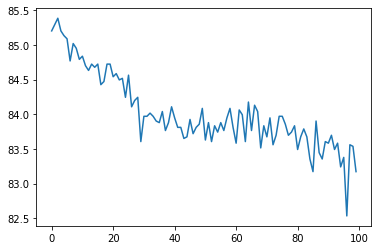

In [ ]:
plt.plot(cluster_precision_per_epoch)
plt.show()

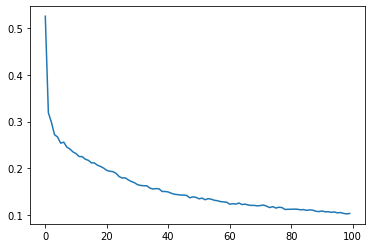

In [ ]:
plt.plot(loss_per_epoch_train)
plt.show()

## Testes

In [ ]:
def cluster_test(dataset, model):

    valid_loader = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=0)
    o, l = [], []
    lab, out = [], []

    for inputs in valid_loader:        

        images, labels = inputs
        images = images.to(device)

        output = model.encoder(images.float())
        output = output.to("cpu")

        output = output.detach().numpy()
        labels = labels.numpy()

        o.append(output)
        l.append(labels)    

    for i in range(len(l)):
        for j in range(len(o[i])):
            lab.append(l[i][j])
            out.append(o[i][j])

    kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.01, verbose=0, random_state=None, copy_x=True, algorithm='elkan')
    label = kmeans.fit_predict(out)

    i00, i01, i02 = 0, 0, 0
    i10, i11, i12 = 0, 0, 0
    i20, i21, i22 = 0, 0, 0

    for i in range(len(label)):

        if lab[i] == 0 and label[i] == 0:
            i00 += 1
        if lab[i] == 0 and label[i] == 1:
            i01 += 1
        if lab[i] == 0 and label[i] == 2:
            i02 += 1

        if lab[i] == 1 and label[i] == 0:
            i10 += 1
        if lab[i] == 1 and label[i] == 1:
            i11 += 1
        if lab[i] == 1 and label[i] == 2:
            i12 += 1

        if lab[i] == 2 and label[i] == 0:
            i20 += 1
        if lab[i] == 2 and label[i] == 1:
            i21 += 1
        if lab[i] == 2 and label[i] == 2:
            i22 += 1

    p = [[i00, i01, i02],
        [i10, i11, i12],
        [i20, i21, i22]]

    print(p)
    print()

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = UNet(3, 3, [64, 128, 256, 512])
model.load_state_dict(torch.load('/content/drive/MyDrive/Guilherme/MODEL_SAVE_v17/conv_autoencoder_200.pth'))

del model.ups
del model.bottleneck
del model.final_conv
del model.encoder.downs[3].conv[5]
del model.encoder.downs[3].conv[4]

# model.eval()

device = get_device()
print(device)
model.to(device)

### Teste1

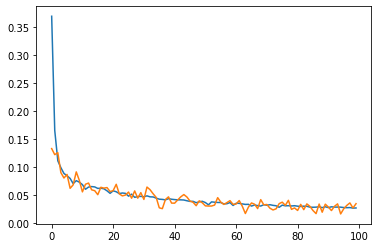

In [ ]:
plt.plot(loss_per_epoch_train)
plt.plot(loss_per_epoch_valid)
plt.show()

In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste1/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(train_set, model)

[[434, 0, 766], [406, 769, 25], [1120, 0, 80]]

[[462, 0, 738], [409, 766, 25], [1118, 0, 82]]

[[434, 0, 766], [409, 766, 25], [1119, 0, 81]]

[[455, 0, 745], [418, 757, 25], [1118, 0, 82]]

[[448, 0, 752], [413, 761, 26], [1119, 0, 81]]

[[443, 0, 757], [413, 761, 26], [1120, 0, 80]]

[[443, 757, 0], [413, 26, 761], [1118, 82, 0]]

[[756, 0, 444], [26, 760, 414], [82, 0, 1118]]

[[450, 0, 750], [419, 755, 26], [1118, 0, 82]]

[[432, 0, 768], [413, 761, 26], [1120, 0, 80]]



In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste1/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(valid_set, model)

[[156, 0, 104], [7, 176, 77], [11, 0, 249]]

[[116, 0, 144], [77, 176, 7], [248, 0, 12]]

[[102, 0, 158], [78, 175, 7], [248, 0, 12]]

[[115, 0, 145], [79, 173, 8], [248, 0, 12]]

[[113, 0, 147], [80, 173, 7], [248, 0, 12]]

[[0, 160, 100], [174, 7, 79], [0, 12, 248]]

[[0, 149, 111], [174, 7, 79], [0, 12, 248]]

[[159, 0, 101], [8, 174, 78], [13, 0, 247]]

[[108, 0, 152], [81, 172, 7], [248, 0, 12]]

[[160, 0, 100], [7, 174, 79], [11, 0, 249]]



### Teste2

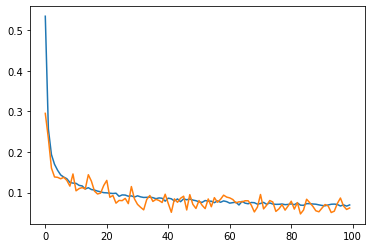

In [ ]:
plt.plot(loss_per_epoch_train)
plt.plot(loss_per_epoch_valid)
plt.show()

In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste2/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(train_set, model)

[[1141, 59, 0], [79, 380, 741], [184, 1007, 9]]

[[1142, 58, 0], [82, 370, 748], [185, 1013, 2]]

[[1142, 0, 58], [85, 746, 369], [187, 1, 1012]]

[[58, 1142, 0], [367, 86, 747], [1012, 188, 0]]

[[0, 58, 1142], [746, 371, 83], [0, 1016, 184]]

[[0, 1142, 58], [745, 85, 370], [0, 184, 1016]]

[[0, 58, 1142], [751, 365, 84], [0, 1016, 184]]

[[0, 58, 1142], [751, 365, 84], [0, 1015, 185]]

[[58, 0, 1142], [363, 753, 84], [1015, 0, 185]]

[[0, 58, 1142], [753, 363, 84], [0, 1015, 185]]



In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste2/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(valid_set, model)

[[0, 248, 12], [166, 12, 82], [1, 21, 238]]

[[12, 248, 0], [72, 17, 171], [220, 37, 3]]

[[0, 12, 248], [171, 72, 17], [3, 222, 35]]

[[12, 248, 0], [73, 17, 170], [225, 35, 0]]

[[248, 12, 0], [14, 75, 171], [21, 239, 0]]

[[12, 248, 0], [74, 16, 170], [225, 35, 0]]

[[248, 0, 12], [16, 171, 73], [35, 0, 225]]

[[248, 12, 0], [16, 73, 171], [36, 224, 0]]

[[12, 248, 0], [73, 16, 171], [225, 35, 0]]

[[0, 12, 248], [171, 73, 16], [0, 224, 36]]



### Teste 3

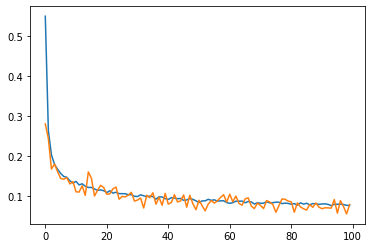

In [ ]:
plt.plot(loss_per_epoch_train)
plt.plot(loss_per_epoch_valid)
plt.show()

In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste3/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(train_set, model)

[[13, 1187, 0], [392, 80, 728], [1035, 162, 3]]

[[0, 1163, 37], [728, 91, 381], [0, 165, 1035]]

[[13, 0, 1187], [369, 732, 99], [1006, 0, 194]]

[[13, 0, 1187], [370, 731, 99], [1007, 0, 193]]

[[0, 1161, 39], [731, 91, 378], [0, 171, 1029]]

[[1188, 12, 0], [95, 376, 729], [174, 1026, 0]]

[[0, 0, 1200], [731, 366, 103], [0, 999, 201]]

[[12, 0, 1188], [375, 730, 95], [1024, 0, 176]]

[[1200, 0, 0], [101, 730, 369], [191, 0, 1009]]

[[0, 1200, 0], [729, 102, 369], [0, 189, 1011]]



In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste3/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(valid_set, model)

[[2, 258, 0], [76, 16, 168], [228, 32, 0]]

[[0, 2, 258], [167, 77, 16], [0, 228, 32]]

[[258, 2, 0], [18, 73, 169], [38, 222, 0]]

[[258, 2, 0], [19, 72, 169], [42, 218, 0]]

[[251, 9, 0], [16, 75, 169], [32, 228, 0]]

[[2, 258, 0], [74, 17, 169], [224, 36, 0]]

[[0, 260, 0], [72, 19, 169], [219, 41, 0]]

[[258, 0, 2], [16, 169, 75], [32, 0, 228]]

[[0, 260, 0], [72, 19, 169], [223, 37, 0]]

[[0, 0, 260], [169, 72, 19], [0, 220, 40]]



### Teste 4

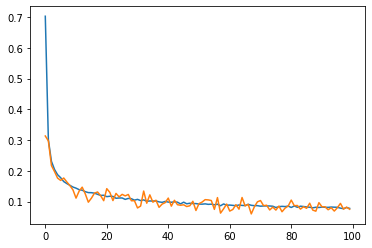

In [ ]:
plt.plot(loss_per_epoch_train)
plt.plot(loss_per_epoch_valid)
plt.show()

In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste4/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(train_set, model)

[[25, 1147, 28], [372, 110, 718], [1007, 168, 25]]

[[21, 37, 1142], [733, 364, 103], [21, 1010, 169]]

[[16, 1150, 34], [741, 102, 357], [19, 173, 1008]]

[[17, 1147, 36], [739, 100, 361], [22, 166, 1012]]

[[17, 36, 1147], [745, 361, 94], [27, 1009, 164]]

[[22, 36, 1142], [746, 357, 97], [33, 1002, 165]]

[[1143, 35, 22], [97, 359, 744], [166, 1007, 27]]

[[1138, 36, 26], [94, 357, 749], [165, 1004, 31]]

[[36, 1139, 25], [358, 94, 748], [1007, 162, 31]]

[[25, 33, 1142], [737, 357, 106], [28, 1004, 168]]



In [ ]:
for i in range(10):

    def get_device():
      if torch.cuda.is_available():
          device = 'cuda:0'
      else:
          device = 'cpu'
      return device

    #Instantiate the model
    model = UNet(3, 3, [64, 128, 256, 512])
    path = '/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste4/conv_autoencoder_' + str((i+1)*10) + '.pth'
    model.load_state_dict(torch.load(path))
    model.eval()

    device = get_device()
    model  = model.to(device)

    cluster_test(valid_set, model)

[[10, 2, 248], [171, 69, 20], [6, 219, 35]]

[[243, 11, 6], [18, 176, 66], [38, 7, 215]]

[[242, 7, 11], [19, 66, 175], [38, 215, 7]]

[[242, 7, 11], [18, 68, 174], [33, 215, 12]]

[[11, 7, 242], [175, 67, 18], [19, 213, 28]]

[[7, 242, 11], [68, 19, 173], [212, 32, 16]]

[[11, 242, 7], [174, 18, 68], [16, 31, 213]]

[[242, 7, 11], [20, 71, 169], [34, 215, 11]]

[[6, 242, 12], [70, 20, 170], [214, 33, 13]]

[[243, 6, 11], [24, 73, 163], [38, 218, 4]]



## Load

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

#Instantiate the model
model = UNet(3, 3, [64, 128, 256, 512])
model.load_state_dict(torch.load('/content/drive/MyDrive/Guilherme/MODEL_SAVE_Teste3/conv_autoencoder_10.pth'))
'''
del model.ups
del model.bottleneck
del model.final_conv
del model.encoder.downs[3].conv[5]
del model.encoder.downs[3].conv[4]
'''
model.eval()

device = get_device()
print(device)
model.to(device)

cuda:0


UNet(
  (encoder): Encoder(
    (downs): ModuleList(
      (0): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [ ]:
cluster_test(train_set, model)
# [[883, 1, 316], [414, 411, 375], [1188, 0, 12]]
# [[887, 313, 0], [467, 376, 357], [1116, 84, 0]]

[[0, 13, 1187], [727, 393, 80], [3, 1035, 162]]

